In [2]:
import numpy as np
import matplotlib.pyplot as plot
from abc import ABC, abstractmethod

class AbstractActivation(ABC):
    
    @abstractmethod
    def activation(self, z):
        pass
    
    @abstractmethod
    def derive_activation(self, z):
        pass
    
class Sigmoid(AbstractActivation):
    
    def activation(self, z):
        return 1./(1. + np.exp(-z))
    
    def derive_activation(self, z):
        return z * (1. - z)
    
class Tanh(AbstractActivation):
    
    def activation(self, z):
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    
    def derive_activation(self, z):
        a = self.activation(z)
        return 1. - a**2

class Relu(AbstractActivation):
    
    def activation(self, z):
        return np.maximum(0,z)
    
    def derive_activation(self, z):
        z[z <= 0] = 0;
        z[z > 0] = 1.;
        return z;

class NeuralNetwork:
    def __init__(self, inodes, hnodes, onodes, lr, activation_function):
        self.inodes = inodes
        self.hnodes = hnodes
        self.onodes = onodes
        
        np.random.seed(0)
        self.bias_hidden = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, 1))
        self.bias_output = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, 1))
        self.weights_ih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.weights_ho = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))
        
        self.lr = lr
        self.activation_function = activation_function
        pass
    
    def train(self, inputs_list, outputs_list):
        # przygotowanie danych
        inputs = np.array(inputs_list, ndmin=2).T
        expected_outputs = np.array(outputs_list, ndmin=2).T

        # suma ważona inputu z wagami do pierwszej warstwie ukrytej
        hidden_inputs = np.dot(self.weights_ih, inputs) + self.bias_hidden      
        hidden_outputs = self.activation_function.activation(hidden_inputs)

        # suma ważona wyjścia z warstwy ukrytej do warstwy wyjściowej
        output_inputs = np.dot(self.weights_ho, hidden_outputs) + self.bias_output
        predicted_outputs = self.activation_function.activation(output_inputs)
        
        # obliczenie błędu i wsteczna propagacja
        output_errors = expected_outputs - predicted_outputs
        b_predicted_outputs = output_errors * self.activation_function.derive_activation(predicted_outputs)
        
        hidden_errors = np.dot(self.weights_ho.T, b_predicted_outputs)
        b_hidden_output = hidden_errors * self.activation_function.derive_activation(hidden_outputs)
        
        # aktualizacja wag
        self.weights_ho += np.dot(b_predicted_outputs, hidden_outputs.T) * self.lr
        self.weights_ih += np.dot(b_hidden_output, inputs.T) * self.lr
        self.bias_output += np.sum(b_predicted_outputs, axis=0, keepdims=True) * self.lr
        self.bias_hidden += np.sum(b_hidden_output, axis=0, keepdims=True) * self.lr
        pass
    
    def feedfoward(self, inputs_list):
        # przygotowanie danych
        inputs = np.array(inputs_list, ndmin=2).T
        
        # suma ważona input-waga input-hidden
        hidden_inputs = np.dot(self.weights_ih, inputs) + self.bias_hidden
        hidden_outputs = self.activation_function.activation(hidden_inputs)
        
        # suma ważona hidden-waga hidden-output
        output_inputs = np.dot(self.weights_ho, hidden_outputs) + self.bias_output
        output_output = self.activation_function.activation(output_inputs)
        
        return output_output
    
def load_data(file,inputs, outputs):
    for line in file:
        values = line.split()
        tmp_list = []
        for i in range(len(values) - 1):
            tmp_list.append(float(values[i]))
        inputs.append(tmp_list)
        outputs.append(float(values[len(values)-1]))

tanh = Tanh()
sigmoid = Sigmoid()
relu = Relu()

In [85]:
mnist_file = open("mnist_train.csv", 'r')
mnist_data = mnist_file.readlines()
mnist_file.close()

input_neurons = 784
hidden_neurons = 100
output_neurons = 10

lr = 0.3
nn = NeuralNetwork(input_neurons, hidden_neurons, output_neurons, lr, sigmoid)

epochs = 5

for epoch in range(epochs):
    for entry in mnist_data:
        mnist_values = entry.split(',')

        #skalowanie danych wejściowych by były w granicach 0 - 1
        mnist_input = (np.asfarray(mnist_values[1:]) / 255.0 * 0.99) + 0.01

        mnist_output = np.zeros(output_neurons) + 0.01
        mnist_output[int(mnist_values[0])] = 0.99
        nn.train(mnist_input, mnist_output)


In [87]:
# sprawdzanie sieci
mnist_test_file = open("mnist_test.csv", 'r')
mnist_test_data = mnist_test_file.readlines()
mnist_test_file.close()

guesses = []
confusion_matrix = np.zeros((output_neurons, output_neurons),dtype=int)

for entry in mnist_test_data:
    mnist_test_values = entry.split(',')
    
    correct_label = int(mnist_test_values[0])

    mnist_test_input = (np.asfarray(mnist_test_values[1:]) / 255.0 * 0.99) + 0.01
    result = nn.feedfoward(mnist_test_input)
    
    result_label = np.argmax(result)

    confusion_matrix[result_label][correct_label] += 1
    if(result_label == correct_label):
        guesses.append(1)
    else:
        guesses.append(0)
        
guesses_array = np.asarray(guesses)
print("Accuracy = ", guesses_array.sum() / guesses_array.size)
print(confusion_matrix)

Accuracy =  0.9743
[[ 970    0    9    1    2    7    9    1    6    4]
 [   0 1126    2    1    0    1    4    4    2    6]
 [   1    3  997    3    0    0    0   15    1    0]
 [   1    1    3  982    0    5    1    0    3    5]
 [   0    0    5    2  951    0    3    0    4    9]
 [   1    1    0    8    1  868    6    0    2    5]
 [   1    1    3    0    6    4  932    0    3    0]
 [   3    0    8    6    2    2    0  998    6    5]
 [   2    3    4    4    1    2    3    0  944    0]
 [   1    0    1    3   19    3    0   10    3  975]]


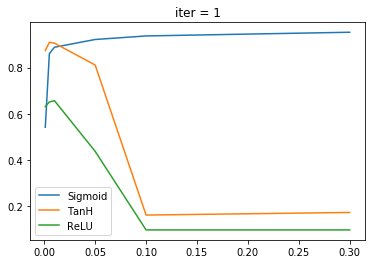

In [61]:
plot.plot([0.3, 0.1, 0.05, 0.01, 0.005, 0.001],[0.9526, 0.9366, 0.9213, 0.8878, 0.8602, 0.5418], label='Sigmoid')
plot.plot([0.3, 0.1, 0.05, 0.01, 0.005, 0.001],[0.1735, 0.1622, 0.8109, 0.9054, 0.9092, 0.8732], label='TanH')
plot.plot([0.3, 0.1, 0.05, 0.01, 0.005, 0.001],[0.098, 0.098, 0.4377, 0.6567, 0.6512, 0.6312], label='ReLU')
plot.title('iter = 1')
plot.legend()

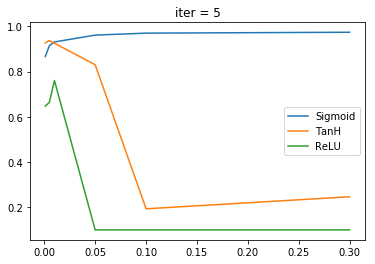

In [257]:
plot.plot([0.3, 0.1, 0.05, 0.01, 0.005, 0.001],[0.9743, 0.9703, 0.9616, 0.9312, 0.9147, 0.8664], label='Sigmoid')
plot.plot([0.3, 0.1, 0.05, 0.01, 0.005, 0.001],[0.245, 0.1916, 0.8302, 0.9255, 0.9369, 0.9274], label='TanH')
plot.plot([0.3, 0.1, 0.05, 0.01, 0.005, 0.001],[0.098, 0.098, 0.098, 0.7602, 0.6634, 0.647], label='ReLU')
plot.title('iter = 5')
plot.legend()

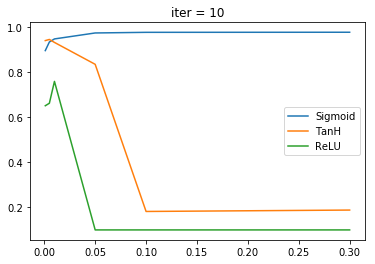

In [258]:
plot.plot([0.3, 0.1, 0.05, 0.01, 0.005, 0.001],[0.9763, 0.9759, 0.9731, 0.9466, 0.9329, 0.8947], label='Sigmoid')
plot.plot([0.3, 0.1, 0.05, 0.01, 0.005, 0.001],[0.1862, 0.18, 0.8338, 0.9311, 0.9443, 0.9392], label='TanH')
plot.plot([0.3, 0.1, 0.05, 0.01, 0.005, 0.001],[0.098, 0.098, 0.098, 0.7579, 0.6608, 0.6498], label='ReLU')
plot.title('iter = 10')
plot.legend()

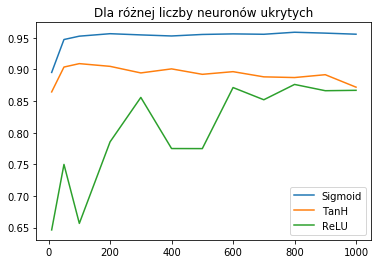

In [80]:
plot.plot([10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],[0.8953, 0.9473, 0.9526, 0.9565, 0.9546, 0.9529, 0.9553, 0.9562, 0.9556, 0.9588, 0.9574, 0.9557], label='Sigmoid')
plot.plot([10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],[0.8645, 0.9038, 0.9092, 0.9049, 0.8945, 0.9009, 0.8923, 0.8965, 0.8883, 0.8872, 0.8917, 0.872], label='TanH')
plot.plot([10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],[0.6464, 0.7499, 0.6567, 0.7856, 0.8558, 0.775, 0.7749, 0.8714, 0.8521, 0.8763, 0.8664, 0.867], label='ReLU')
plot.title('Dla różnej liczby neuronów ukrytych')
plot.legend()

In [81]:
np.mean([0.9526, 0.9366, 0.9213, 0.8878, 0.8602, 0.5418, 0.9743, 0.9703, 0.9616, 0.9312, 0.9147, 0.8664, 0.9763, 0.9759, 0.9731, 0.9466, 0.9329, 0.8947])

0.9121277777777776

In [82]:
np.mean([0.1735, 0.1622, 0.8109, 0.9054, 0.9092, 0.8732, 0.245, 0.1916, 0.8302, 0.9255, 0.9369, 0.9274, 0.1862, 0.18, 0.8338, 0.9311, 0.9443, 0.9392])

0.6614222222222222

In [83]:
np.mean([0.098, 0.098, 0.4377, 0.6567, 0.6512, 0.6312, 0.098, 0.098, 0.098, 0.7602, 0.6634, 0.647, 0.098, 0.098, 0.098, 0.7579, 0.6608, 0.6498])

0.40555

In [84]:
np.mean([0.9092,0.9369, 0.9443])

0.9301333333333334